<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,9,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG > 1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
Dlum = xGASST[:,1]
lgMstar = xGASST[:,2]
petro90r = xGASST[:,3]
lgmust = xGASST[:,4]
lgSFR_tot_median = xGASST[:,5]
SFR_best = xGASST[:,6]
SFRerr_best = xGASST[:,7]
HIsrc = xGASST[:,8]
HI_FLAG = xGASST[:,9]
lgMHI = xGASST[:,10]
lgGF = xGASST[:,11]

In [4]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
# Subtracting no HI detection
# All HI-detected galaxy properties below
HIndet = np.where(HIsrc >= 4)[0]

zSDSS1 = np.delete(zSDSS, (HIndet))
Dlum1 = np.delete(Dlum, (HIndet))
lgMstar1 = np.delete(lgMstar, (HIndet))
petro90r1 = np.delete(petro90r, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
lgSFR1 = np.log10(SFR_best1)
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

# Subtracting HI detection
# All no-HI-detected galaxies below
HIdet = np.where(HIsrc < 4)[0]

zSDSS2 = np.delete(zSDSS, (HIdet))
Dlum2 = np.delete(Dlum, (HIdet))
lgMstar2 = np.delete(lgMstar, (HIdet))
petro90r2 = np.delete(petro90r, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# The bottom two prints should sum to the top print statement
print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

# IMPORTANT
# Usually a 1, a or det at the end of a variable name mean it relates to an array where HI was detected
# Usually a 2, b or ndet at the end of a variable name mean it relates to an array where no HI was detected
# A lg in a variable name means that the array has been run through the np.log10() operation
# A p or n at the front of a variable means that it is the positive or negative bound of an error calculation

1066
691
375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


In [5]:
# Finding the running median of the HI detections
# Arrays for the bins
bins = np.linspace(9, 12, 26)
bins2 = np.linspace(-1.25, 1, 13)

# Array of zeroes to store the median of each bin
mHIa = np.zeros(len(bins))
median1 = np.zeros(len(bins))
MAD1 = np.zeros(len(bins))

mHIb = np.zeros(len(bins2))
median2 = np.zeros(len(bins2))
MAD2 = np.zeros(len(bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median1[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  MAD1[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  mHIa[i] = median1[i]

for i in range (len(bins2) -1):
  # Median and MAD for HI of galaxies against SFR
  median2[i] = np.median(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  MAD2[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  mHIb[i] = median2[i]

# Working out the upper and lower bounds of the median absolute deviation
pMAD1 = mHIa + MAD1
nMAD1 = mHIa - MAD1
pMAD2 = mHIb + MAD2
nMAD2 = mHIb - MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


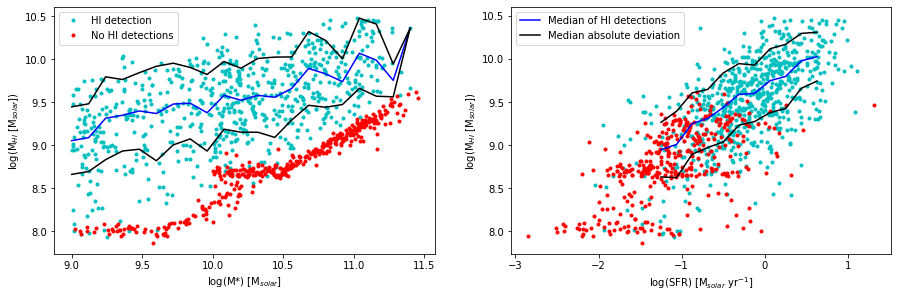

In [6]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

In [7]:
# DHI- MHI relation
# For HI detections
lgDHI1 = 0.506*lgMHI1 - 3.293
MHI1 = 10**lgMHI1
DHI1 = 10**lgDHI1
RHI1 = 0.5*DHI1

# For no HI detection
lgDHI2 = 0.506*lgMHI2 - 3.293
MHI2 = 10**lgMHI2
DHI2 = 10**lgDHI2
RHI2 = 0.5*DHI2

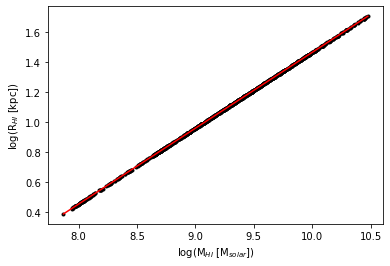

In [8]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI
# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(np.log10(MHI), np.log10(RHI), 'k.')
plt.ylabel('log(R$_{HI}$ [kpc])')
plt.xlabel('log(M$_{HI}$ [M$_{solar}$])')

# Fitting a line to the RHI-MHI relation
x = np.log10(MHI)
p = np.linspace(min(x), max(x), 100)
y = np.log10(RHI)
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
plt.plot(p, linfun(p, *popt), 'r');

-0.9639211636046359
-1.2288723228732537


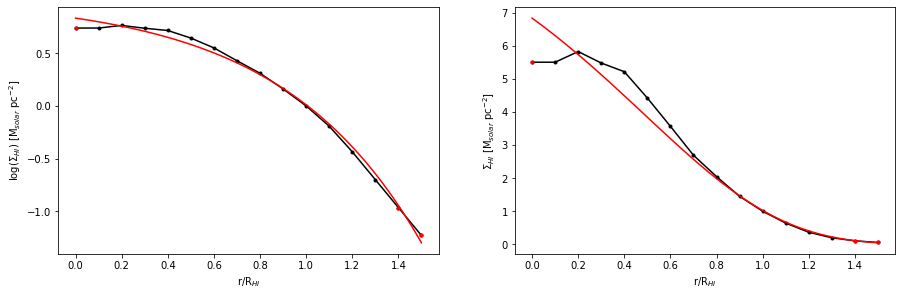

In [9]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)
rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)

# This data has no 0 point and some of the xGASS samples will extend further than the 1.3 r/RHI in the rrHI array, out to 1.5
# Therefore the following will linearly extrapolate:
# Back to the zero-point
x1 = np.flip(rrHI)
y1 = lgSigHI
f1 = interpolate.interp1d(x1, y1, fill_value = "extrapolate")
zpoint = f1(max(x1))
# Forward to 1.5r/RHI
x2 = rrHI
y2 = y1
f2 = interpolate.interp1d(x2, y2, fill_value = "extrapolate")
z1point = f2(1.4)
z2point = f2(1.5)

# New arrays to fit the surface density profile to
newrrHI = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
newSigHI=np.array([(10**zpoint),5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2,(10**z1point),(10**z2point)])
newlgSigHI = np.log10(newSigHI)

# Fitting a curve to the extrapolated data
x = newrrHI
p = np.linspace(0, max(newrrHI), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.plot(0, zpoint, 'r.')
plt.plot(1.4, z1point, 'r.')
plt.plot(1.5, z2point, 'r.');

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, 10**curvefun(p, *popt), 'r-')
plt.plot(0, 10**zpoint, 'r.')
plt.plot(1.4, 10**z1point, 'r.')
plt.plot(1.5, 10**z2point, 'r.');

print(z1point)
print(z2point)

In [10]:
# Converting the petrosian flux in the r band from arcsec to parsec:
# Using the astropy cosmology module
# Assuming the following cosmology
cosmology = FlatLambdaCDM(H0 = 70, Om0 = 0.3, Tcmb0 = 2.273)
# Converting the data, where .arcsec_per_kpc_proper is the equation of proper distance, using the redshift of the galaxies
arckpc1 = cosmology.arcsec_per_kpc_proper(zSDSS1)
rkpc = petro90r1/arckpc1
# Normalise r90 by dividing by RHI
rnorma = (rkpc/RHI1)
print(rnorma[0:11])

[0.41045764 0.47962425 0.401255   0.69175735 0.42232271 0.47379863
 0.34860138 0.31304847 0.39714913 0.22548857 0.26414082] kpc / arcsec


In [11]:
# Using the a set of equations:
# Angular diameter distance of a galaxy at redshift z:
# DA(z) = DL(z)/(1+z)^2
# Definition of angular diameter distance:
# Theta = size(l)/DA(z)
# Combining these to an expression of the size of a galaxy in kpc, will allow the conversion of the petrosian 90 r band data from units of arcsec to parsec
# This then allows for the calculation of r90/RHI and the scaling to find the surface density for each galaxy, using the profile estabilished above
# Function:
def arcpc(z, theta, Dlumin):
  arcrad = ((2*np.pi)/360) * (1/3600)
  return (Dlumin* arcrad * theta) / ((1+z)**2)

rpc = arcpc(zSDSS, petro90r, Dlum)
rpc1 = arcpc(zSDSS1, petro90r1, Dlum1)
rpc2 = arcpc(zSDSS2, petro90r2, Dlum2)

# Normalising the converted r band petrosian flux by dividing by RHI
rnorm = (rpc*1000) / RHI
rnorm1 = (rpc1*1000) / RHI1
rnorm2 = (rpc2*1000) / RHI2
print(rnorm1[0:11])
print(rpc1[0:11])

[0.41035736 0.47965283 0.40139577 0.69165092 0.42234525 0.47374361
 0.34869168 0.31324044 0.39724232 0.22558298 0.26414426]
[0.00755527 0.00581247 0.00590205 0.00587477 0.00626824 0.00522386
 0.00907427 0.00499721 0.00577332 0.00882625 0.00525813]


In [12]:
# Conditions for the dataset
# 1) When r > 1.5RHI, MHIout = 0, i.e- do not integrate
# 2) When r < 1.5RHI, MHIout is found by integrating from r --> 1.5 RHI
# Testing if any data points fall outside 1.5 RHI
# Applying these conditions to the data:
rnormbig1 = np.where(rnorm1 > 1.5)[0]
print(rnormbig1)
rnormbig2 = np.where(rnorm2 > 1.5)[0]
print(rnormbig2)

[63]
[  2  49  57 170 171 212 213 250]


In [13]:
# To recover the x-axis with units of kpc we multiply the r/RHI by RHI
r = rnorm * RHI
r1 = rnorm1 * RHI1
r2 = rnorm2 * RHI2
newlen = len(np.where(r1 > 0 )[0]) + len(np.where(r2 > 0)[0])
print(rnorm1[0:11] )
print(r1[0:11])
print(petro90r1[0:11])
print(RHI1[0:11])
print(len(r1), len(r2), newlen)
print(r[0])

[0.41035736 0.47965283 0.40139577 0.69165092 0.42234525 0.47374361
 0.34869168 0.31324044 0.39724232 0.22558298 0.26414426]
[7.55527428 5.81247389 5.90204885 5.87477124 6.26823996 5.22385812
 9.07426765 4.9972127  5.7733184  8.82625216 5.25812837]
[10.51  7.01 16.5  16.28  8.53  6.68 11.38 13.9  15.84 24.52 14.7 ]
[18.41145049 12.11808528 14.70381414  8.4938386  14.84150711 11.02676209
 26.02375756 15.95328061 14.53349295 39.12641025 19.90627522]
691 375 1066
7.555274283461987


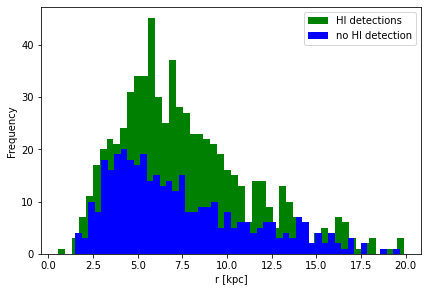

In [14]:
# Historgram plots to determine the how the investigated galaxies are distributed
plt.figure(figsize = (15,10))
'''
plt.subplot(221)
plt.hist(rnorm1, bins = 50, color = 'g', label = 'HI detections')
plt.hist(rnorm2, bins = 50, color = 'b', label = 'no HI detection')
plt.legend(loc= 'upper left')
plt.xlabel('r/RHI')
plt.ylabel('Counts')
'''
plt.subplot(222)
plt.hist(r1, bins = 50, color = 'g', label = 'HI detections')
plt.hist(r2, bins = 50, color = 'b', label = 'no HI detection')
plt.xlabel('r [kpc]')
plt.ylabel('Frequency')
plt.legend(loc= 'upper right');

[ 0.          1.84114505  3.6822901   5.52343515  7.36458019  9.20572524
 11.04687029 12.88801534 14.72916039 16.57030544 18.41145049 20.25259554
 22.09374058 23.93488563 25.77603068 27.61717573]
[20.89687431  0.08994049  4.67868621  1.02893407]


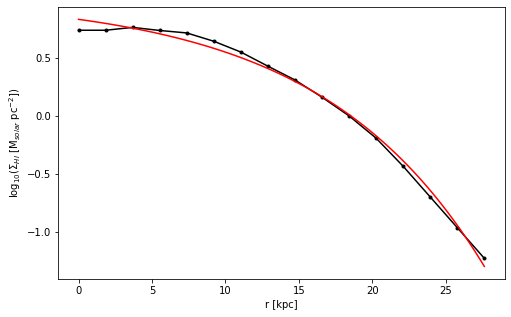

In [15]:
# Each galaxy from the xGASS representative sample can be assumed to follow the same srface desnity profile as modelled previously
# Rescaling the x-axis by multiplying r/RHI by the 'i'th value in the RHI array determined from the mass relation
# IN this case multiplying the r/RHI in the mass relation by the value of RHI for the first galaxy
ScaleR0 = newrrHI*RHI[0]

# Rescaling the curvefitting routine to use the rescaled x-axis
x = ScaleR0
p = np.linspace(0, max(ScaleR0), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(ScaleR0, newlgSigHI, 'k.-')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]')
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])');
print(ScaleR0)
print(popt)

In [16]:
# To compare the predicted global HI mass to the measured global HI mass we need to integrate under the surface-density profile
# This will be run for all of the galaxies and then the expected global HI mass can be plotted against the measured global HI mass
# The less scatter present in this relation the more accurate the process to determine the HI mass outside the optical region will be

# Computing the integration via the trapezium method:
x_arr0 = ScaleR0
y_arr0 = curvefun(x_arr0, *popt)
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0[0:15])
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred0 = areas0
print(mHIpred0)
print(lgMHI[0])
print((10**mHIpred0)*1000)
print((10**lgMHI)[0])

6.705986084860455
9.603
5081431609.899483
4008667176.273026


[ 0.          2.1850934   4.37018679  6.55528019  8.74037358 10.92546698
 13.11056037 15.29565377 17.48074716 19.66584056 21.85093395 24.03602735
 26.22112074 28.40621414 30.59130753 32.77640093]
[ 0.83478352  0.8298503   0.82479175  0.81960468  0.81428582  0.80883183
  0.80323927  0.79750462  0.79162427  0.78559452  0.77941158  0.77307154
  0.76657043  0.75990415  0.75306849  0.74605917  0.73887176  0.73150175
  0.72394448  0.71619521  0.70824906  0.70010102  0.69174597  0.68317864
  0.67439365  0.66538546  0.6561484   0.64667665  0.63696426  0.62700511
  0.61679293  0.6063213   0.59558361  0.58457312  0.57328288  0.5617058
  0.54983458  0.53766175  0.52517965  0.51238042  0.49925601  0.48579815
  0.47199837  0.45784798  0.44333807  0.42845952  0.41320295  0.39755877
  0.38151711  0.36506789  0.34820075  0.33090507  0.31316997  0.29498428
  0.27633654  0.25721503  0.23760771  0.21750222  0.19688593  0.17574584
  0.15406865  0.13184071  0.10904804  0.08567628  0.06171072  0.03713627
  

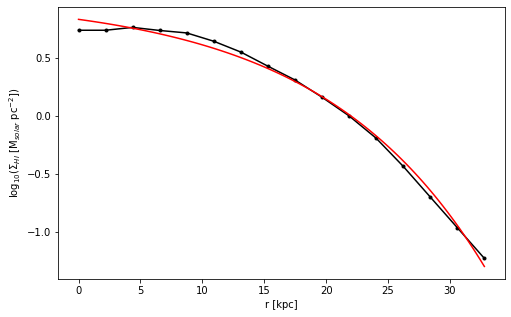

In [24]:
ScaleR0 = newrrHI*RHI[501]

# Rescaling the curvefitting routine to use the rescaled x-axis
x = ScaleR0
p = np.linspace(0, max(ScaleR0), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(ScaleR0, newlgSigHI, 'k.-')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]')
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])')

x_arr0 = ScaleR0
y_arr0 = curvefun(x_arr0, *popt)
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0[0:15])
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred501 = areas0

print(ScaleR0)
print(y_arr0)
print(mHIpred501)
print(lgMHI[501])
print((10**mHIpred501)*1000)
print((10**lgMHI)[501])

TypeError: ignored

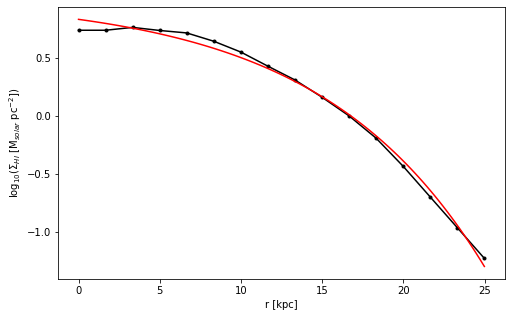

In [28]:
ScaleR0 = newrrHI*RHI[1065]

# Rescaling the curvefitting routine to use the rescaled x-axis
x = ScaleR0
p = np.linspace(0, max(ScaleR0), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(ScaleR0, newlgSigHI, 'k.-')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]')
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])')

x_arr0 = ScaleR0
y_arr0 = curvefun(p, *popt)
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0[0:15])
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred1065 = areas0/2

def trapezoidal(f, a, b, n):
  h = float(b - a) / n
  s = 0.0
  s += h * f(a)
  for i in range(1, n):
      s += h * f(a + i*h)
  s += (h * f(b))/2
  return s
'''
b = y_arr0[15]
a = y_arr0[0]
n = dx0
f = curvefun(p, 1,1,1,1)
'''
print(trapezoidal(x**2 ,5,10,100))

print(curvefun(p, *popt))
print(y_arr0)
print(mHIpred1065)
print(lgMHI[1065])

[ 6.32120559e-01 -1.82689332e+01 -1.00827572e+03 -5.28632383e+04
 -2.76894275e+06 -1.45032817e+08 -7.59658567e+09 -3.97896935e+11
 -2.08412012e+13 -1.09162859e+15 -5.71777491e+16 -2.99487850e+18
 -1.56866917e+20 -8.21643673e+21 -4.30363736e+23 -2.25417600e+25]
10.26


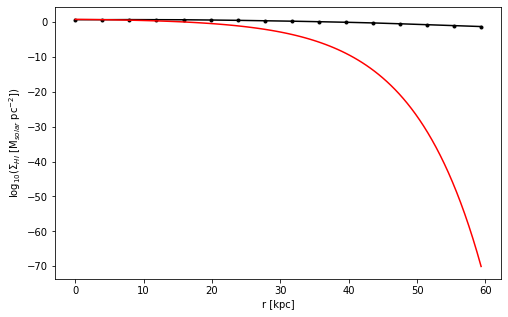

In [19]:
ScaleR0 = newrrHI*RHI[23]

# Rescaling the curvefitting routine to use the rescaled x-axis
x = ScaleR0
p = np.linspace(0, max(ScaleR0), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
#popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(ScaleR0, newlgSigHI, 'k.-')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]')
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])')
'''
x_arr0 = ScaleR0
y_arr0 = curvefun(x_arr0, *popt)
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0[0:15])
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred = areas0
'''
print(curvefun(x, 1,1,1,1))
print(lgMHI[23])

In [20]:
# Each galaxy from the xGASS representative sample can be assumed to follow the same srface desnity profile as modelled previously
# Rescaling the x-axis by multiplying r/RHI by the 'i'th value in the RHI array determined from the mass relation
# Fitting routine:
def curvefun(x, a, b, c, d): 
  return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])

# Loop the process of rescaling, creating the surface-density profile and computing the integration for all galaxies
# Creating arrays of zeroes to store output data
rrl = len(newrrHI)
Rl = len(RHI)
ScaleR = np.zeros(rrl)
areas = np.zeros(Rl)
lgMHIpred = np.zeros(Rl)

for i in range(Rl):
  ScaleR = newrrHI*RHI[i]
  x = ScaleR
  y = newlgSigHI
  #print(i)
  def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
  p0 = np.array([1,1,1,1])
  popt, pcov = curve_fit(curvefun, x, y, p0, maxfev = 100000)
  p = np.linspace(min(ScaleR), max(ScaleR), 100)
  x_arr = ScaleR
  y_arr = curvefun(p, *popt)
  dx = (x_arr[15] - x_arr[0]) / len(x_arr[0:15])
  areas[i] = np.trapz(y_arr[0:15], x_arr[0:15], dx = dx)
  lgMHIpred[i] = areas[i]/2

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


9.603
10.262667947049819


(0.0, 10000000000.0)

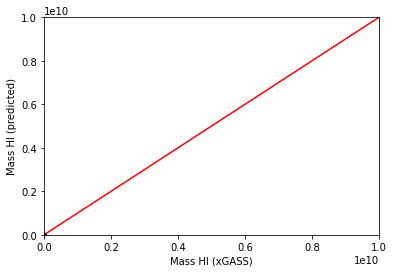

In [23]:
# Comparing how well the total predicted HI mass compares to the total HI mass from xGASS
# Converting log(HI mass) to HI mass
MassHI = lgMHI
MassHIpred = lgMHIpred

print(MassHI[0])
print(MassHIpred[0])
x1 = np.linspace(0, 10000000000, 1000)
y1 = np.linspace(0, 10000000000, 1000)

plt.plot(x1, y1, 'r-')
plt.plot(MassHI[0:500], MassHIpred[0:500], 'k.')
plt.xlabel('Mass HI (xGASS)')
plt.ylabel('Mass HI (predicted)')
plt.ylim(0, max(y1))
plt.xlim(0, max(x1))

In [22]:
'''
rrl = len(newrrHI)
Rl = len(RHI)
ScaleR = np.zeros((rrl, Rl))
areas = np.zeros(Rl)
mHIpred = np.zeros(Rl)
x = np.zeros(rrl)

for i in range(rrl):
  for j in range(Rl):
    ScaleR[i, j] = newrrHI[i] * RHI[j]
  x = ScaleR[:,:i]
  print(x)
  y = newlgSigHI

  def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
  p0 = np.array([1,1,1,1])
  popt, pcov = curve_fit(curvefun, x, y, p0)

  x_arr = ScaleR
  y_arr = curvefun(x_arr, *popt)
  dx = (x_arr[15] - x_arr[0]) / len(x_arr[0:15])
  areas = np.trapz(y_arr[0:15], x_arr[0:15], dx = dx)
  mHIpred = areas
'''



'\nrrl = len(newrrHI)\nRl = len(RHI)\nScaleR = np.zeros((rrl, Rl))\nareas = np.zeros(Rl)\nmHIpred = np.zeros(Rl)\nx = np.zeros(rrl)\n\nfor i in range(rrl):\n  for j in range(Rl):\n    ScaleR[i, j] = newrrHI[i] * RHI[j]\n  x = ScaleR[:,:i]\n  print(x)\n  y = newlgSigHI\n\n  def curvefun(x, a, b, c, d): \n    return (-a*np.exp((x*b)- c) + d)\n  p0 = np.array([1,1,1,1])\n  popt, pcov = curve_fit(curvefun, x, y, p0)\n\n  x_arr = ScaleR\n  y_arr = curvefun(x_arr, *popt)\n  dx = (x_arr[15] - x_arr[0]) / len(x_arr[0:15])\n  areas = np.trapz(y_arr[0:15], x_arr[0:15], dx = dx)\n  mHIpred = areas\n'